## This project predict whether a transaction will happen or not in Santander
The data is from Kaggle. It is a classification problem.

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
#from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import xgboost as xgb
warnings.filterwarnings('ignore')

## Data Load and Pre-check

In [2]:
#load both training and test data
PATH="D:/kaggle/santandar/"
train=pd.read_csv(PATH+"train.csv")
test=pd.read_csv(PATH+"test.csv")


In [3]:
print('Train data dimension is '+str(train.shape))
train.head()

Train data dimension is (200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
print('Test data dimension is '+str(test.shape))
test.head()

Test data dimension is (200000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [52]:
##check missing data
def check_missing(data):
    na_num=pd.isna(train).sum()
    na_percent=na_num/list(train.shape)[0]*100
    na_percent
    missing_table=pd.concat([na_num,na_percent],keys=['Number of missing data','Percent of missing data'],axis=1)
    return missing_table.astype(bool).sum(axis=0)

In [53]:
check_missing(train)
##No missing data in training set

Number of missing data     0
Percent of missing data    0
dtype: int64

In [54]:
check_missing(test)
##No missing data in test set

Number of missing data     0
Percent of missing data    0
dtype: int64

## EDA

In [56]:
#check data distribution
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [57]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [60]:
##check the differenc between training and test data stats
diff=train.describe().iloc[:,train.describe().columns!='target']-test.describe()

In [61]:
diff
## stats difference between training and test data is not significant 

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.021177,-0.003378,0.007740,0.008315,0.001934,-0.014760,-0.006215,0.016707,0.007027,-0.002171,...,0.044673,-0.019861,0.001894,0.009758,-0.003183,-0.008431,0.012437,-0.004270,0.001537,-0.080195
std,0.003335,0.009535,0.007006,-0.009405,0.006693,-0.006026,0.001921,-0.006406,-0.000741,0.003204,...,0.008683,-0.001918,-0.001543,-0.003568,-0.005490,-0.000306,0.008024,0.000721,0.002228,0.039426
min,0.219700,0.000000,-0.238100,-0.017800,-0.409600,-4.795600,0.130900,-0.364000,-0.549500,-0.272800,...,0.000000,-0.284700,-0.473600,-0.370300,-0.688400,-0.349100,-0.265400,-0.209000,-0.284700,0.605000
25%,0.010875,-0.039900,-0.013125,0.023575,-0.007900,0.001050,-0.004900,0.009900,-0.013900,-0.005000,...,0.036175,-0.009100,0.006800,-0.003000,-0.004975,-0.010000,0.001675,-0.007275,-0.017575,-0.084475
50%,0.010950,-0.017550,0.019300,0.002650,0.008500,0.000950,-0.006500,0.034100,0.021700,-0.002400,...,0.041200,-0.031250,0.008700,-0.032150,-0.019650,-0.010700,0.005300,-0.004600,-0.009350,-0.093600
75%,0.018600,0.015225,0.021675,-0.003500,0.007725,-0.017775,-0.002800,0.008350,0.007875,-0.000400,...,0.069725,-0.018575,-0.006500,0.031600,0.004800,-0.008300,0.036925,-0.002600,0.019525,-0.098600
max,-2.008400,0.991700,0.638900,0.046300,0.634300,-0.002100,0.145200,-0.601000,0.485800,0.147000,...,-1.918100,0.000000,0.397400,0.649200,-0.019000,-0.272500,2.400800,-0.275400,-0.459300,0.593300


Text(0.5,1,'Whisker plots for test data')

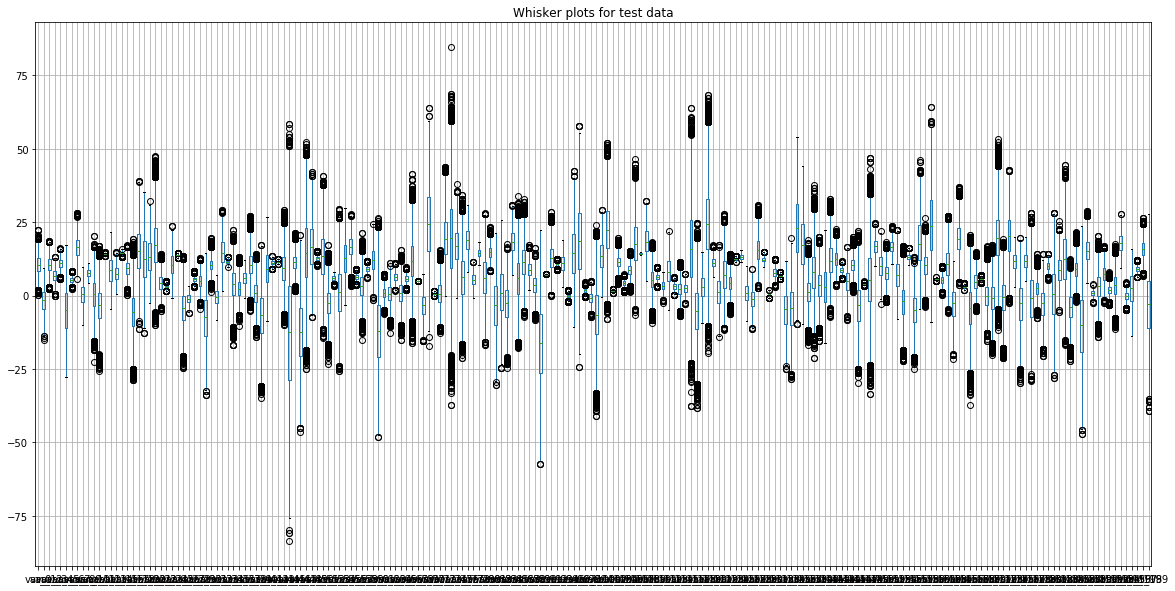

In [77]:

plt.figure(figsize=(20,10))

test.loc[:,test.columns!='ID_code'].boxplot(column=list(test.columns)[1:])
plt.title("Whisker plots for test data")


Text(0.5,1,'Whisker plots for traing data')

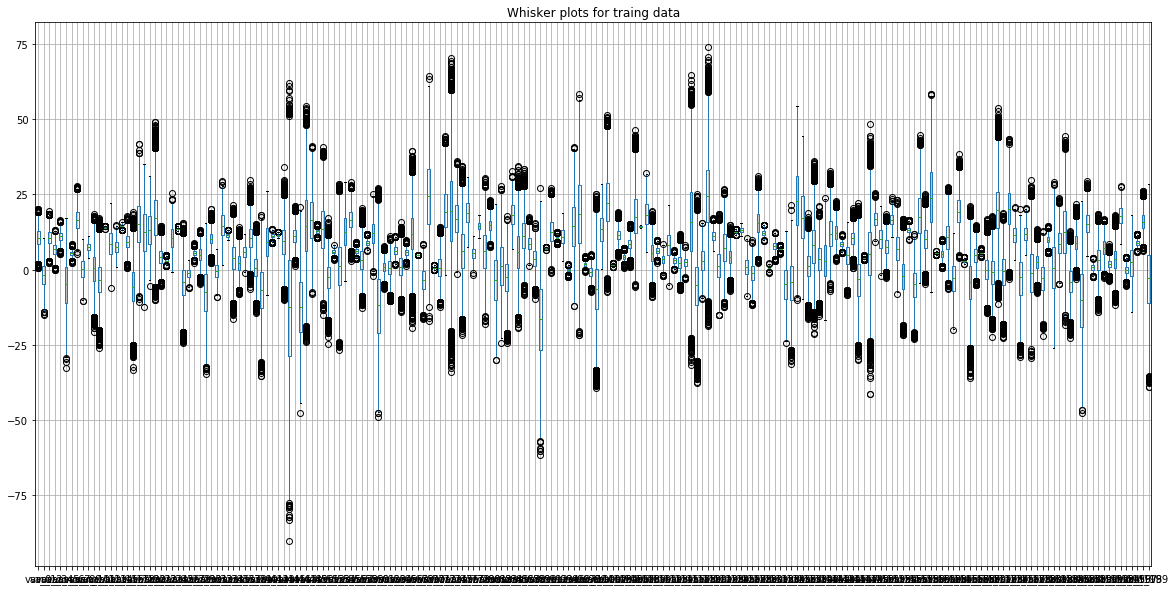

In [78]:
plt.figure(figsize=(20,10))
train.loc[:,train.columns!=('ID_code' or 'target')].boxplot(column=list(train.columns)[2:])
plt.title("Whisker plots for traing data")

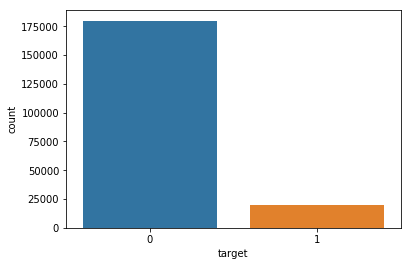

In [79]:
##check target in training data
sns.countplot(train['target'])
##more '0' than '1', unbalanced data

In [81]:
##Check density distribution of X by target
def plot_density(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

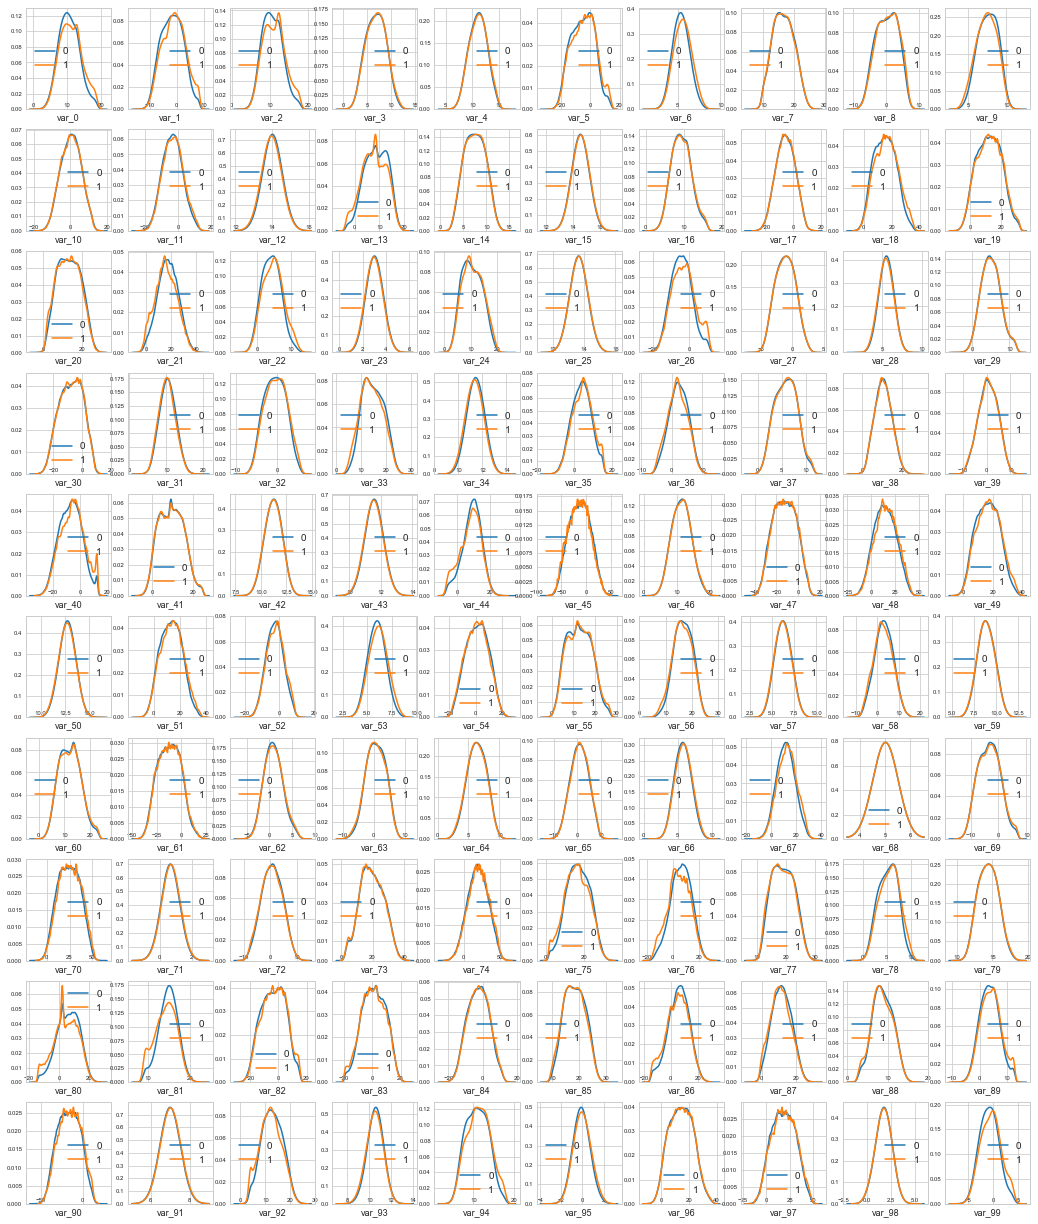

In [82]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)
## Generally, variable 0 to 99 (grouped by target 0 and 1) share the similar distribution. More attention to var_0,1,2,5,6,13,18,21,22...

In [93]:
##calculate the correlation between features in training data
features = train.columns.values[2:]
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.loc[::2,:].head(10)
##10 least correalted variables

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
2,var_173,var_6,5.942735e-08
4,var_126,var_109,1.313947e-07
6,var_144,var_27,1.772502e-07
8,var_177,var_100,3.116544e-07
10,var_181,var_12,4.033775e-07
12,var_150,var_116,6.628008e-07
14,var_142,var_44,7.934263e-07
16,var_13,var_171,1.181142e-06
18,var_126,var_69,1.218374e-06


In [94]:
##10 most correlated variables
correlations.loc[::2,].tail(10)

,level_0,level_1,0
39780,var_1,var_80,0.008855
39782,var_172,var_81,0.008936
39784,var_122,var_132,0.008956
39786,var_80,var_6,0.008958
39788,var_146,var_169,0.009071
39790,var_183,var_189,0.009359
39792,var_174,var_81,0.009490
39794,var_81,var_165,0.009714
39796,var_53,var_148,0.009788
39798,var_26,var_139,0.009844


## Model

In [5]:
## get training X and Y
features=[c for c in train.columns.values][2:]
train_x=train[features]
train_y=train['target']
test_x=test[features]
true_y=pd.read_csv(PATH+'sample_submission.csv')['target']

In [6]:
##Gradient Boosting model

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}




folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    print("Fold {}".format(fold))
    tain_data = lgb.Dataset(train_x.loc[train_idx], label=train_y.loc[train_idx])
    val_data = lgb.Dataset(train_x.loc[val_idx], label=train_y.loc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, tain_data, num_round, valid_sets = [tain_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_x.loc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_x, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(train_y, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89904	valid_1's auc: 0.880364
[2000]	training's auc: 0.911204	valid_1's auc: 0.888868
[3000]	training's auc: 0.91903	valid_1's auc: 0.893151
[4000]	training's auc: 0.924854	valid_1's auc: 0.896012
[5000]	training's auc: 0.929701	valid_1's auc: 0.897714
[6000]	training's auc: 0.933934	valid_1's auc: 0.898494
[7000]	training's auc: 0.93786	valid_1's auc: 0.898994
[8000]	training's auc: 0.941613	valid_1's auc: 0.89928
[9000]	training's auc: 0.945152	valid_1's auc: 0.899671
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
[11000]	training's auc: 0.951758	valid_1's auc: 0.900177
[12000]	training's auc: 0.954863	valid_1's auc: 0.899992
[13000]	training's auc: 0.957793	valid_1's auc: 0.899881
[14000]	training's auc: 0.96065	valid_1's auc: 0.899628
Early stopping, best iteration is:
[11045]	training's auc: 0.951908	valid_1's auc: 0.900223
Fold 1
Training until validation scores don't improve

[11000]	training's auc: 0.951843	valid_1's auc: 0.900587
[12000]	training's auc: 0.954894	valid_1's auc: 0.900639
Early stopping, best iteration is:
[9691]	training's auc: 0.947612	valid_1's auc: 0.900898
CV score: 0.90053 


In [7]:
##misclassification in test data
dif=np.round(predictions,0)-np.array(true_y)
mis_percent=np.abs(dif).sum()/len(list(true_y))*100
mis_percent

3.2520000000000002

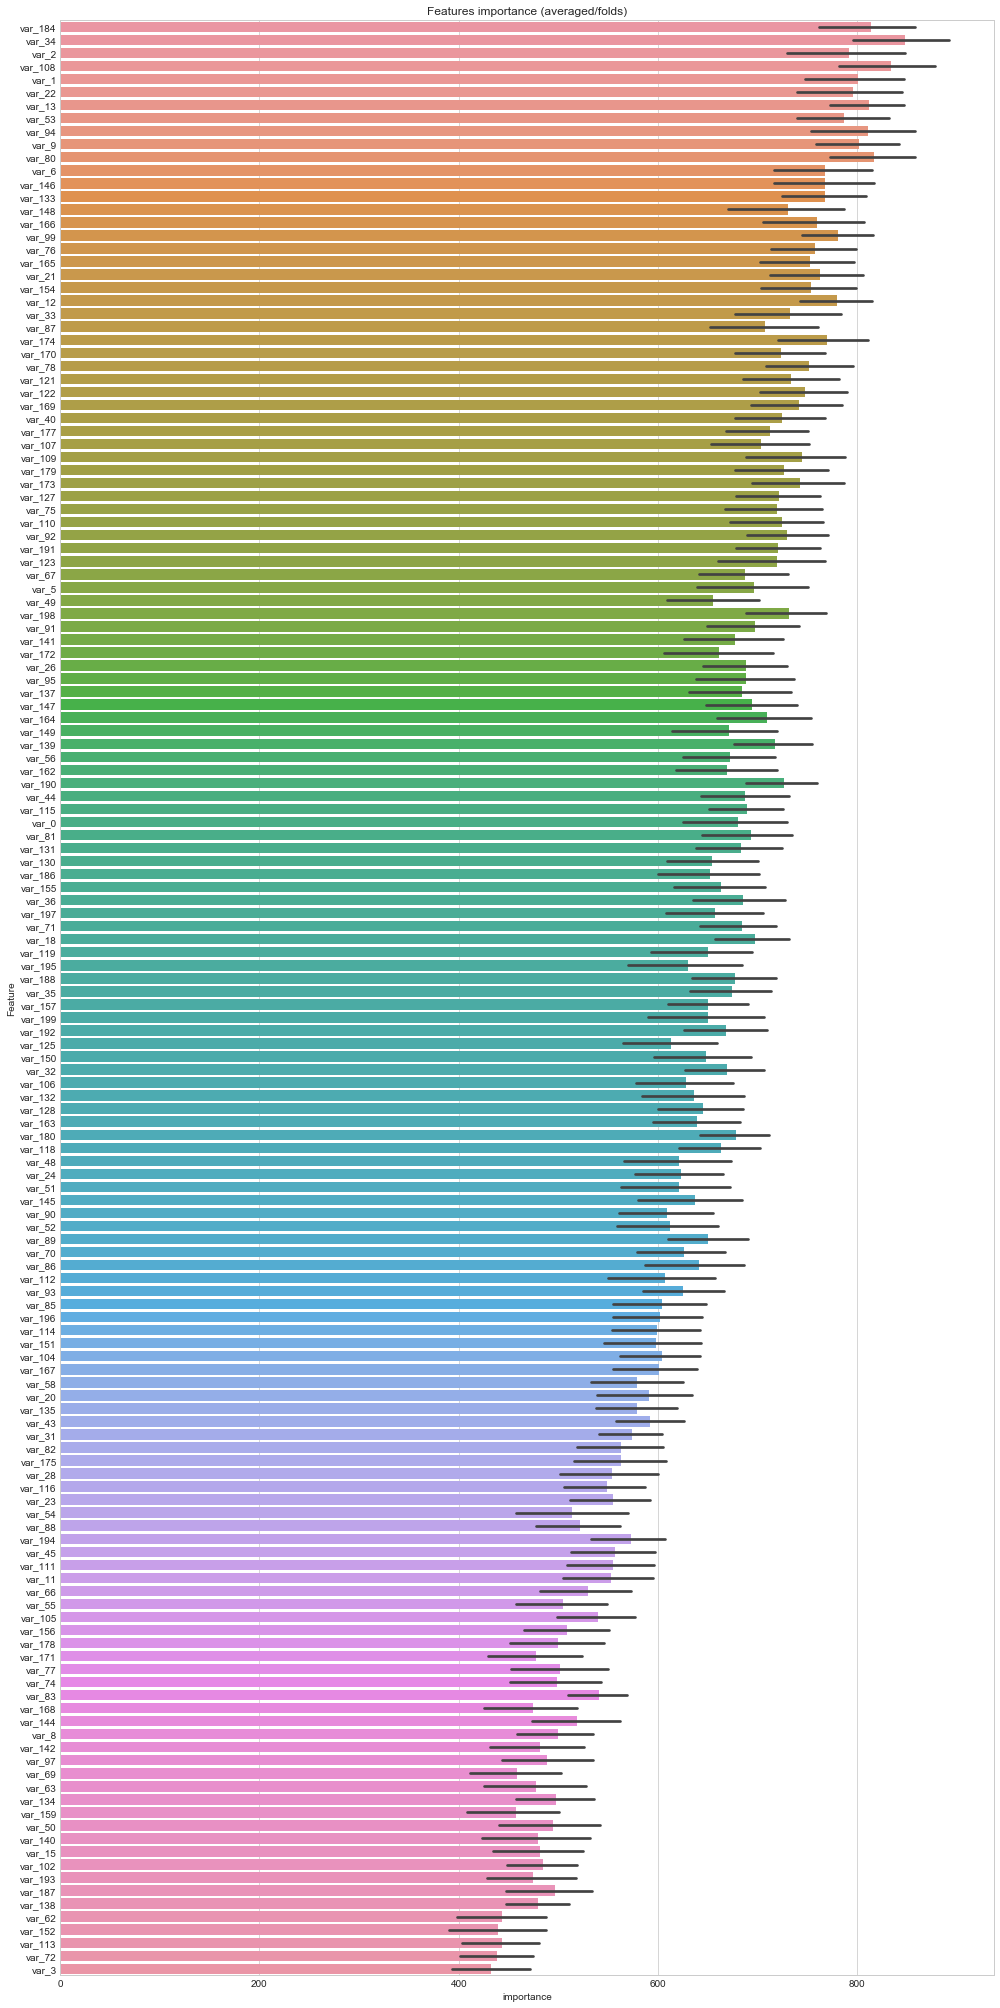

In [125]:
##check important features
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [8]:
##submission
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [9]:
##XGB
train_stats = train_x.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,10.679914,3.040051,0.4084,8.453850,10.52475,12.758200,20.3150
var_1,200000.0,-1.627622,4.050044,-15.0434,-4.740025,-1.60805,1.358625,10.3768
var_2,200000.0,10.715192,2.640894,2.1171,8.722475,10.58000,12.516700,19.3530
var_3,200000.0,6.796529,2.043319,-0.0402,5.254075,6.82500,8.324100,13.1883
var_4,200000.0,11.078333,1.623150,5.0748,9.883175,11.10825,12.261125,16.6714
var_5,200000.0,-5.065317,7.863267,-32.5626,-11.200350,-4.83315,0.924800,17.2516
var_6,200000.0,5.408949,0.866607,2.3473,4.767700,5.38510,6.003000,8.4477
var_7,200000.0,16.545850,3.418076,5.3497,13.943800,16.45680,19.102900,27.6918
var_8,200000.0,0.284162,3.332634,-10.5055,-2.317800,0.39370,2.937900,10.1513
var_9,200000.0,7.567236,1.235070,3.9705,6.618800,7.62960,8.584425,11.1506


In [10]:
##data normalization
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
train = norm(train_x)
test = norm(test_x)

In [129]:
train

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-0.577100,-1.273734,0.451706,-0.833707,0.235571,-0.536429,-0.334925,0.608749,-1.561576,-1.473792,...,0.263373,-1.149155,0.817467,-0.411012,0.168704,-1.578113,1.022128,-0.373967,-1.026395,0.214134
1,0.269958,-0.622136,1.190357,-0.688845,0.790973,1.539897,0.244461,-0.003525,0.858972,0.419299,...,0.966609,0.093604,0.443622,1.908760,-0.817592,1.522338,1.067651,-0.129399,0.825415,0.505684
2,-0.681112,-0.276066,0.516987,0.536515,-0.305476,-0.511032,1.769834,-0.564748,-1.561366,-1.307405,...,-0.072093,0.777995,-0.174130,-0.412315,1.151588,2.297364,-1.617902,-0.695139,-0.381448,0.356681
3,0.125158,-0.129425,-0.667574,0.195354,0.927990,0.410671,0.500632,-0.474200,-1.843906,0.548765,...,0.270215,-0.891454,-0.818466,-0.478547,1.607865,-0.789515,-0.959017,1.501741,0.697116,-0.543500
4,-0.277303,0.035610,0.817681,-0.077829,0.738605,0.955572,0.613370,0.791542,1.794748,0.090006,...,-1.036189,0.688986,-1.405984,1.468532,-1.501098,-0.958471,0.297626,0.645536,0.706316,-0.525374
5,0.261965,-0.170511,0.716730,0.895538,-0.071610,1.097027,-1.011702,-0.386285,0.990609,-1.285949,...,-2.092413,-0.276491,2.274966,-0.724312,-0.972385,0.820982,-1.086732,0.931878,-1.092620,-0.137350
6,0.371436,0.381335,-0.517170,-1.225912,0.035220,-0.375732,0.908314,-1.307388,-1.398972,0.288213,...,1.216810,-0.326239,1.085387,-0.790093,0.107687,0.508327,1.248002,0.223673,-1.655234,0.011193
7,0.946723,-1.570471,1.197476,0.392484,-1.493413,0.749856,0.323158,1.691112,1.434463,-0.299689,...,2.178888,-0.294154,1.395245,0.619817,1.641675,-0.164766,0.350997,0.559384,-2.394039,0.652149
8,1.785229,1.004982,1.217583,-0.569578,-1.402787,1.427946,-1.104940,-1.860828,-1.041927,1.227027,...,-0.395761,2.418768,-0.195031,-0.479374,-1.006897,-1.295612,-0.619070,-0.771092,1.209148,0.782892
9,0.601597,0.889354,-0.688855,-0.658600,1.556213,-1.426962,0.755534,0.086350,-0.046648,0.324649,...,-0.587760,-0.371256,-0.602492,0.089360,-1.007726,0.411921,2.168054,-1.079460,0.121815,1.684031


In [11]:
sc=StandardScaler()
train=sc.fit_transform(train)
test=sc.transform(test)

In [132]:
train

array([[-0.57710174, -1.27373702,  0.45170728, ..., -0.37396811,
        -1.02639785,  0.21413482],
       [ 0.26995857, -0.62213756,  1.19036045, ..., -0.12939961,
         0.82541712,  0.50568523],
       [-0.68111341, -0.2760664 ,  0.51698836, ..., -0.69514059,
        -0.38144932,  0.35668144],
       ...,
       [ 0.17870987, -0.84546901, -0.07667568, ..., -0.20904171,
        -0.67680579,  0.72102365],
       [-0.31746727, -1.72398014,  1.09630117, ...,  1.22180338,
        -0.11352617, -1.01298853],
       [ 0.06456676, -1.00810962,  0.53130173, ..., -0.78389704,
        -1.24290845,  0.33196403]])

In [12]:
xgb_preds = []
K = 10
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [13]:
for train_index, val_index in kf.split(train):
    train_X, valid_X = train[train_index], train[val_index]
    train_yy, valid_y = train_y[train_index], train_y[val_index]
    xgb_params = {'max_depth': 6, 'objective': 'binary:logistic','eval_metric':'auc'}

    d_train = xgb.DMatrix(train_X, train_yy)
    d_valid = xgb.DMatrix(valid_X, valid_y)
    d_test = xgb.DMatrix(test)    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(xgb_params, d_train,200,watchlist,early_stopping_rounds=100)                     
    xgb_pred = model.predict(d_test)
    xgb_preds.append(list(xgb_pred))

[0]	train-auc:0.652089	valid-auc:0.628568
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[1]	train-auc:0.694468	valid-auc:0.670729
[2]	train-auc:0.710747	valid-auc:0.687719
[3]	train-auc:0.733229	valid-auc:0.696931
[4]	train-auc:0.748266	valid-auc:0.709586
[5]	train-auc:0.766133	valid-auc:0.72893
[6]	train-auc:0.778635	valid-auc:0.73821
[7]	train-auc:0.790992	valid-auc:0.746119
[8]	train-auc:0.801414	valid-auc:0.752448
[9]	train-auc:0.808142	valid-auc:0.754752
[10]	train-auc:0.8173	valid-auc:0.758749
[11]	train-auc:0.826157	valid-auc:0.765315
[12]	train-auc:0.834732	valid-auc:0.770725
[13]	train-auc:0.841155	valid-auc:0.775268
[14]	train-auc:0.849021	valid-auc:0.780623
[15]	train-auc:0.85567	valid-auc:0.784963
[16]	train-auc:0.860903	valid-auc:0.788569
[17]	train-auc:0.866376	valid-auc:0.791313
[18]	train-auc:0.871204	valid-auc:0.793599
[19]	train-auc:0.875737	valid-auc:0.797344
[20]	train-

[187]	train-auc:0.99472	valid-auc:0.866505
[188]	train-auc:0.994839	valid-auc:0.866538
[189]	train-auc:0.994912	valid-auc:0.866483
[190]	train-auc:0.995014	valid-auc:0.866654
[191]	train-auc:0.995107	valid-auc:0.866517
[192]	train-auc:0.995154	valid-auc:0.866569
[193]	train-auc:0.995234	valid-auc:0.866559
[194]	train-auc:0.995331	valid-auc:0.866709
[195]	train-auc:0.995407	valid-auc:0.866707
[196]	train-auc:0.995461	valid-auc:0.86653
[197]	train-auc:0.995542	valid-auc:0.866381
[198]	train-auc:0.995658	valid-auc:0.866879
[199]	train-auc:0.995746	valid-auc:0.866914
[0]	train-auc:0.650009	valid-auc:0.642877
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[1]	train-auc:0.687767	valid-auc:0.676771
[2]	train-auc:0.70898	valid-auc:0.694582
[3]	train-auc:0.733141	valid-auc:0.704833
[4]	train-auc:0.750812	valid-auc:0.717961
[5]	train-auc:0.762755	valid-auc:0.728538
[6]	train-auc:0.776932	valid-auc:0.

[174]	train-auc:0.993672	valid-auc:0.867483
[175]	train-auc:0.993864	valid-auc:0.867259
[176]	train-auc:0.993992	valid-auc:0.867259
[177]	train-auc:0.994032	valid-auc:0.867499
[178]	train-auc:0.994187	valid-auc:0.867647
[179]	train-auc:0.994292	valid-auc:0.867756
[180]	train-auc:0.99438	valid-auc:0.867712
[181]	train-auc:0.994442	valid-auc:0.867709
[182]	train-auc:0.994563	valid-auc:0.867725
[183]	train-auc:0.994652	valid-auc:0.867558
[184]	train-auc:0.994723	valid-auc:0.867411
[185]	train-auc:0.994796	valid-auc:0.867428
[186]	train-auc:0.994883	valid-auc:0.867293
[187]	train-auc:0.994988	valid-auc:0.867278
[188]	train-auc:0.995045	valid-auc:0.867247
[189]	train-auc:0.995146	valid-auc:0.867165
[190]	train-auc:0.995177	valid-auc:0.867018
[191]	train-auc:0.995238	valid-auc:0.867086
[192]	train-auc:0.995353	valid-auc:0.866992
[193]	train-auc:0.995466	valid-auc:0.867126
[194]	train-auc:0.995568	valid-auc:0.867291
[195]	train-auc:0.995611	valid-auc:0.867352
[196]	train-auc:0.995709	valid-au

[161]	train-auc:0.991651	valid-auc:0.864336
[162]	train-auc:0.991753	valid-auc:0.864311
[163]	train-auc:0.991891	valid-auc:0.864487
[164]	train-auc:0.992042	valid-auc:0.864438
[165]	train-auc:0.992184	valid-auc:0.864494
[166]	train-auc:0.992253	valid-auc:0.864406
[167]	train-auc:0.992398	valid-auc:0.86416
[168]	train-auc:0.992545	valid-auc:0.864113
[169]	train-auc:0.992654	valid-auc:0.864305
[170]	train-auc:0.992716	valid-auc:0.864221
[171]	train-auc:0.992789	valid-auc:0.863919
[172]	train-auc:0.992923	valid-auc:0.864127
[173]	train-auc:0.993064	valid-auc:0.864173
[174]	train-auc:0.993274	valid-auc:0.864608
[175]	train-auc:0.993408	valid-auc:0.864732
[176]	train-auc:0.993506	valid-auc:0.864778
[177]	train-auc:0.993665	valid-auc:0.864811
[178]	train-auc:0.993744	valid-auc:0.864987
[179]	train-auc:0.99384	valid-auc:0.865286
[180]	train-auc:0.993949	valid-auc:0.86537
[181]	train-auc:0.994005	valid-auc:0.865472
[182]	train-auc:0.994052	valid-auc:0.865611
[183]	train-auc:0.9941	valid-auc:0.

[148]	train-auc:0.989941	valid-auc:0.863336
[149]	train-auc:0.990087	valid-auc:0.863408
[150]	train-auc:0.990268	valid-auc:0.863735
[151]	train-auc:0.990417	valid-auc:0.863827
[152]	train-auc:0.990523	valid-auc:0.863878
[153]	train-auc:0.990678	valid-auc:0.86389
[154]	train-auc:0.990794	valid-auc:0.863881
[155]	train-auc:0.990921	valid-auc:0.864175
[156]	train-auc:0.991122	valid-auc:0.864343
[157]	train-auc:0.99125	valid-auc:0.864272
[158]	train-auc:0.991346	valid-auc:0.864406
[159]	train-auc:0.991418	valid-auc:0.864569
[160]	train-auc:0.991523	valid-auc:0.864547
[161]	train-auc:0.991678	valid-auc:0.864723
[162]	train-auc:0.991752	valid-auc:0.864861
[163]	train-auc:0.991867	valid-auc:0.864909
[164]	train-auc:0.991949	valid-auc:0.865107
[165]	train-auc:0.992148	valid-auc:0.865072
[166]	train-auc:0.992314	valid-auc:0.865097
[167]	train-auc:0.992441	valid-auc:0.864995
[168]	train-auc:0.992636	valid-auc:0.864915
[169]	train-auc:0.992752	valid-auc:0.865135
[170]	train-auc:0.992921	valid-auc

[135]	train-auc:0.987179	valid-auc:0.864323
[136]	train-auc:0.987428	valid-auc:0.864523
[137]	train-auc:0.987602	valid-auc:0.86446
[138]	train-auc:0.987781	valid-auc:0.864311
[139]	train-auc:0.987973	valid-auc:0.864241
[140]	train-auc:0.988168	valid-auc:0.864371
[141]	train-auc:0.988316	valid-auc:0.864673
[142]	train-auc:0.988527	valid-auc:0.864834
[143]	train-auc:0.988727	valid-auc:0.864914
[144]	train-auc:0.988909	valid-auc:0.864887
[145]	train-auc:0.989112	valid-auc:0.865075
[146]	train-auc:0.989297	valid-auc:0.864917
[147]	train-auc:0.989578	valid-auc:0.864833
[148]	train-auc:0.989681	valid-auc:0.864789
[149]	train-auc:0.989831	valid-auc:0.86486
[150]	train-auc:0.989973	valid-auc:0.864767
[151]	train-auc:0.990132	valid-auc:0.864807
[152]	train-auc:0.990396	valid-auc:0.864902
[153]	train-auc:0.990518	valid-auc:0.864877
[154]	train-auc:0.99073	valid-auc:0.864549
[155]	train-auc:0.99089	valid-auc:0.864627
[156]	train-auc:0.990971	valid-auc:0.864631
[157]	train-auc:0.99106	valid-auc:0.

[122]	train-auc:0.983887	valid-auc:0.868075
[123]	train-auc:0.984125	valid-auc:0.868349
[124]	train-auc:0.984338	valid-auc:0.86857
[125]	train-auc:0.984592	valid-auc:0.868221
[126]	train-auc:0.984903	valid-auc:0.867916
[127]	train-auc:0.985106	valid-auc:0.867978
[128]	train-auc:0.985306	valid-auc:0.868406
[129]	train-auc:0.985664	valid-auc:0.868357
[130]	train-auc:0.985901	valid-auc:0.86841
[131]	train-auc:0.986161	valid-auc:0.86857
[132]	train-auc:0.986351	valid-auc:0.8684
[133]	train-auc:0.98658	valid-auc:0.868415
[134]	train-auc:0.986765	valid-auc:0.868398
[135]	train-auc:0.986987	valid-auc:0.868271
[136]	train-auc:0.987231	valid-auc:0.868363
[137]	train-auc:0.98751	valid-auc:0.868262
[138]	train-auc:0.987747	valid-auc:0.868683
[139]	train-auc:0.988006	valid-auc:0.868829
[140]	train-auc:0.988205	valid-auc:0.868873
[141]	train-auc:0.988406	valid-auc:0.869174
[142]	train-auc:0.988518	valid-auc:0.869331
[143]	train-auc:0.988672	valid-auc:0.869443
[144]	train-auc:0.988804	valid-auc:0.86

[109]	train-auc:0.980714	valid-auc:0.864768
[110]	train-auc:0.981016	valid-auc:0.864791
[111]	train-auc:0.981386	valid-auc:0.86468
[112]	train-auc:0.981762	valid-auc:0.865066
[113]	train-auc:0.982043	valid-auc:0.865135
[114]	train-auc:0.982397	valid-auc:0.865424
[115]	train-auc:0.982763	valid-auc:0.86577
[116]	train-auc:0.982955	valid-auc:0.865912
[117]	train-auc:0.983263	valid-auc:0.866083
[118]	train-auc:0.983551	valid-auc:0.865898
[119]	train-auc:0.983916	valid-auc:0.865707
[120]	train-auc:0.984137	valid-auc:0.865683
[121]	train-auc:0.984382	valid-auc:0.865686
[122]	train-auc:0.984718	valid-auc:0.865829
[123]	train-auc:0.984939	valid-auc:0.865677
[124]	train-auc:0.985331	valid-auc:0.866002
[125]	train-auc:0.985525	valid-auc:0.866109
[126]	train-auc:0.985759	valid-auc:0.866362
[127]	train-auc:0.985923	valid-auc:0.866494
[128]	train-auc:0.986094	valid-auc:0.866683
[129]	train-auc:0.986305	valid-auc:0.866896
[130]	train-auc:0.986421	valid-auc:0.867023
[131]	train-auc:0.986621	valid-auc

[96]	train-auc:0.976147	valid-auc:0.865067
[97]	train-auc:0.976667	valid-auc:0.865682
[98]	train-auc:0.976987	valid-auc:0.866045
[99]	train-auc:0.977333	valid-auc:0.866548
[100]	train-auc:0.977648	valid-auc:0.866855
[101]	train-auc:0.977921	valid-auc:0.866735
[102]	train-auc:0.978253	valid-auc:0.866824
[103]	train-auc:0.978457	valid-auc:0.867235
[104]	train-auc:0.978885	valid-auc:0.867397
[105]	train-auc:0.97922	valid-auc:0.867591
[106]	train-auc:0.979422	valid-auc:0.867428
[107]	train-auc:0.979643	valid-auc:0.867347
[108]	train-auc:0.97999	valid-auc:0.86762
[109]	train-auc:0.980344	valid-auc:0.867875
[110]	train-auc:0.980659	valid-auc:0.86794
[111]	train-auc:0.981024	valid-auc:0.868108
[112]	train-auc:0.981422	valid-auc:0.868487
[113]	train-auc:0.98175	valid-auc:0.868459
[114]	train-auc:0.982068	valid-auc:0.868571
[115]	train-auc:0.982313	valid-auc:0.868899
[116]	train-auc:0.98255	valid-auc:0.868961
[117]	train-auc:0.982742	valid-auc:0.869116
[118]	train-auc:0.982985	valid-auc:0.86944

[82]	train-auc:0.969378	valid-auc:0.852612
[83]	train-auc:0.969715	valid-auc:0.853499
[84]	train-auc:0.970277	valid-auc:0.853791
[85]	train-auc:0.970652	valid-auc:0.854053
[86]	train-auc:0.971126	valid-auc:0.854551
[87]	train-auc:0.971598	valid-auc:0.854943
[88]	train-auc:0.97218	valid-auc:0.85549
[89]	train-auc:0.972518	valid-auc:0.85605
[90]	train-auc:0.972882	valid-auc:0.856146
[91]	train-auc:0.973437	valid-auc:0.856238
[92]	train-auc:0.973916	valid-auc:0.856462
[93]	train-auc:0.974282	valid-auc:0.856288
[94]	train-auc:0.974802	valid-auc:0.856819
[95]	train-auc:0.97522	valid-auc:0.857051
[96]	train-auc:0.975642	valid-auc:0.857298
[97]	train-auc:0.976143	valid-auc:0.857557
[98]	train-auc:0.976523	valid-auc:0.857775
[99]	train-auc:0.976955	valid-auc:0.858237
[100]	train-auc:0.977248	valid-auc:0.858077
[101]	train-auc:0.977384	valid-auc:0.858415
[102]	train-auc:0.9778	valid-auc:0.858595
[103]	train-auc:0.978246	valid-auc:0.858785
[104]	train-auc:0.978672	valid-auc:0.85903
[105]	train-a

[69]	train-auc:0.961655	valid-auc:0.8538
[70]	train-auc:0.962427	valid-auc:0.85424
[71]	train-auc:0.963114	valid-auc:0.854672
[72]	train-auc:0.963907	valid-auc:0.854958
[73]	train-auc:0.964472	valid-auc:0.855401
[74]	train-auc:0.965151	valid-auc:0.85546
[75]	train-auc:0.96578	valid-auc:0.855765
[76]	train-auc:0.966214	valid-auc:0.855817
[77]	train-auc:0.96685	valid-auc:0.856128
[78]	train-auc:0.967514	valid-auc:0.856806
[79]	train-auc:0.968036	valid-auc:0.856803
[80]	train-auc:0.968705	valid-auc:0.85715
[81]	train-auc:0.9692	valid-auc:0.857494
[82]	train-auc:0.969733	valid-auc:0.857745
[83]	train-auc:0.970093	valid-auc:0.858095
[84]	train-auc:0.970744	valid-auc:0.858313
[85]	train-auc:0.971213	valid-auc:0.85863
[86]	train-auc:0.971683	valid-auc:0.858259
[87]	train-auc:0.972337	valid-auc:0.85824
[88]	train-auc:0.972809	valid-auc:0.858307
[89]	train-auc:0.973211	valid-auc:0.858382
[90]	train-auc:0.973653	valid-auc:0.858635
[91]	train-auc:0.97403	valid-auc:0.85901
[92]	train-auc:0.974507	

In [17]:
xgb_preds

[[0.060086638,
  0.4425747,
  0.17463589,
  0.26400232,
  0.04933114,
  0.0015436787,
  0.0028175602,
  0.1284363,
  0.00302655,
  0.0034505478,
  0.095583424,
  0.029693253,
  0.052154843,
  0.023017397,
  0.013515214,
  0.020199442,
  0.4144149,
  0.027525242,
  0.20429963,
  0.006958683,
  0.73647726,
  0.053807724,
  0.006388745,
  0.009196869,
  0.007047109,
  0.038920965,
  0.047276385,
  0.0015208372,
  0.5189321,
  0.06814042,
  0.024580913,
  0.023882441,
  0.6510606,
  0.14877623,
  0.017731423,
  0.011692045,
  0.00688046,
  0.032141786,
  0.0071420213,
  0.0059900037,
  0.045464545,
  0.0017387847,
  0.008656899,
  0.0041751363,
  0.021362895,
  0.018912083,
  0.0034326531,
  0.008970079,
  0.0043708445,
  0.017193163,
  0.16723707,
  0.005528017,
  0.0045734323,
  0.037449446,
  0.0117026735,
  0.1653046,
  0.07927227,
  0.0018441026,
  0.025722034,
  0.024806885,
  0.07931199,
  0.016018795,
  0.0086408155,
  0.0017277745,
  0.025976244,
  0.01574633,
  0.0024024462,
  0.

In [16]:
preds=[]
for i in range(len(xgb_preds[0])):
    sum=0
    for j in range(K):
        sum+=xgb_preds[j][i]
    preds.append(sum / K)

output = pd.DataFrame({'ID_code': id, 'target': preds})
##misclassification in test data
dif=np.round(list(output['target']),0)-np.array(true_y)
mis_percent=np.abs(dif).sum()/len(list(true_y))*100
mis_percent
##XGB seems work better than GB

2.4604999999999997

In [27]:
##prepare for submission
true_y=pd.read_csv(PATH+'sample_submission.csv')
sub_df2 = pd.DataFrame({"ID_code":true_y["ID_code"].values})
sub_df2["target"] =preds
sub_df2.to_csv("10-foldCV_avg_sub.csv", index=False)


## Reference:
https://www.kaggle.com/gpreda/santander-eda-and-prediction

https://www.kaggle.com/rstogi896/xgboost